# After Using Previous Notebooks Use This Notebook to Make Predictions

In [95]:
# Imports --- All of this may not be vital

from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_roc_curve, log_loss, f1_score, fbeta_score, recall_score, precision_score, confusion_matrix
# from sklearn.metrics import log_loss, f1_score, fbeta_score, recall_score, precision_score, confusion_matrix
import urllib.request, json
from skimage.filters import threshold_otsu
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import *
# Homemade functions required
from data_prep_functions import *
from interpro_scraping import interpro_scraping_pandas

### Import Data

In [108]:
### import data used to train classifiers ###

plasma_total_data_names = pd.read_excel("data/"+'gt15_plasma_features_names_biopy.xlsx', header=0, index_col=0)
csf_total_data_names = pd.read_excel("data/"+'gt15_csf_features_names_biopy.xlsx', header=0,index_col=0)

## sort into names and features
features_plasma = plasma_total_data_names.copy()
features_plasma = features_plasma.drop(['Corona'], axis=1)
names_plasma = plasma_total_data_names['Corona'].copy()

features_csf = csf_total_data_names.copy()
features_csf = features_csf.drop(['Corona'], axis=1) 
names_csf = csf_total_data_names['Corona'].copy()

### create a merged set
features_plasma_labeled = features_plasma.copy()
features_csf_labeled = features_csf.copy()

features_plasma_labeled['phase_plasma'] = 1
features_csf_labeled['phase_plasma'] = 0

features_merged = features_plasma_labeled.append(features_csf_labeled, ignore_index=True)
names_merged = names_plasma.append(names_csf, ignore_index=True)

# set with no phase labeling names are identical to names merged
features_merged_naive = features_merged.drop(['phase_plasma'], axis=1)

# print(plasma_total_data_names.shape, csf_total_data_names.shape, features_test.shape) ## in case you need to see shapes

## there is a known error here, sometimes there is an Unnamed column just drop it code is available in a 
#lower cell (scaling cell), its a holdover from two merged sets



In [109]:
## Use this space to import test data ### 

features_test = pd.read_excel("data/"+'proteins_selected_for_testing_complete.xlsx', header=0, index_col = 0)
# features_test = features_test.append(pd.read_excel('complete_test_features_biopy_v2.xlsx', header=0, index_col = 0))

# features_verification = pd.read_excel('complete_verification_features_biopy_covid.xlsx', header=0, index_col = 0)
#features_test = features_test.drop(['Protein names'], axis=1)

In [110]:
### if were not going to be using NETSURFP 

features_for_prediction = pd.read_excel("data/"+'proteins_selected_for_testing_complete.xlsx', header=0, index_col = 0)
# print(list(features_for_prediction.columns))
# subset_features = features_merged_naive[list(features_for_prediction.columns)]

### Scale Data To Make it Work Well

In [111]:
scaler = MinMaxScaler()
total_data = features_merged_naive.copy()  ## for a regular netsurfp included case
# total_data = subset_features.copy() ### for a subset case --- use this one
total_data = total_data.fillna(0)
total_data_with_names = total_data.copy()
total_data = total_data.drop(['Protein names'], axis=1)
scaler = scaler.fit(total_data)
scaled_df = pd.DataFrame(scaler.transform(total_data), columns=total_data.columns)
print(scaled_df.shape)

# total_data_labeled = features_merged.copy()
# total_data_labeled = total_data_labeled.fillna(0)
# total_data_labeled = total_data_labeled.drop(['Protein names'], axis=1)
# scaled_df_total = pd.DataFrame(scaler.transform(total_data_labeled), columns=total_data_labeled.columns)

scaled_df_phase = scaled_df.copy()
scaled_df_phase['phase_plasma'] = features_merged['phase_plasma'].copy()

plasma_data = scaled_df_phase[scaled_df_phase.phase_plasma==1]
plasma_data = plasma_data.drop(['phase_plasma'], axis=1)
scaled_df_plasma = plasma_data #pd.DataFrame(scaler.transform(plasma_data), columns=plasma_data.columns)

csf_data = scaled_df_phase[scaled_df_phase.phase_plasma==0]
csf_data = csf_data.drop(['phase_plasma'], axis=1)
scaled_df_csf = csf_data #pd.DataFrame(scaler.transform(csf_data), columns=csf_data.columns)

### UNCOMMENT this section for a REGULAR RUN
#features = features_merged_naive.copy()  # change the dataframe that you want to use here
features_test = features_test.fillna(0)
features_test_names = features_test.copy()
features_test = features_test.drop(['Protein names'], axis=1)
scaled_test_df = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)


scaled_df = scaled_df.drop(['Unnamed: 0.1'], axis=1)
scaled_df_phase = scaled_df_phase.drop(['Unnamed: 0.1'], axis=1)
scaled_test_df = scaled_test_df.drop(['Unnamed: 0.1'], axis=1)

(174, 90)


In [112]:
#### SCALE DATA THAT IS FROM 

scaled_features_for_prediction = pd.DataFrame(scaler.transform(features_for_prediction.copy().drop(['Protein names'], axis=1)), 
                                             columns=features_for_prediction.drop(['Protein names'], axis=1).columns)



### Data to be Put into classifier

In [113]:
### Data put into classifier and classified


df_local_features_train = scaled_df.copy()
# df_local_protein_names_train = features_test_names['Protein names']
df_local_names = names_merged.copy()

df_local_features_classify = scaled_features_for_prediction.copy().drop(['Unnamed: 0.1'], axis=1)
df_local_protein_names_classify = features_for_prediction['Protein names'].copy()

### to keep some things kosher later
df_local_features_train_copy = scaled_df.copy()
df_local_names_copy = names_merged.copy()
df_local_features_classify_copy = df_local_features_classify.copy()
df_local_protein_names_classify_copy = df_local_protein_names_classify.copy()

### Classifier

In [105]:
k_fold_splits = 100
predictions = pd.DataFrame()



feature_imp = pd.DataFrame(columns=list(df_local_features_train.columns))
first_frame = True
correctness_frame = pd.DataFrame()
metrics_frame = pd.DataFrame()

# set_size_adjust = (scaled_df.shape[0]/scaled_df_plasma.shape[0]) *.1 # used to retain the same number of samples in the test set
# #split up our data
i = 0
# skf = KFold(n_splits=k_fold_splits, shuffle=True)
sss = StratifiedShuffleSplit(n_splits=k_fold_splits, test_size=0.1, random_state=2020)

for train_index, test_index in sss.split(df_local_features_train, df_local_names):
# for train_index, test_index in sss.split(scaled_df_plasma, names_plasma):
    X_train = df_local_features_train.iloc[train_index]
    X_test = df_local_features_train.iloc[test_index] #
    y_train = df_local_names.iloc[train_index]
    y_test = df_local_names.iloc[test_index] #


    
    # Create and Train
    rfc=RandomForestClassifier(criterion='gini', n_jobs=-1, random_state=2020, n_estimators=1000) 
                               #n_estimators=110, min_samples_split=4, min_samples_leaf= 2, max_features= 'log2', max_depth = 10)
    
    sme = SMOTE(random_state=2020, sampling_strategy=.5, n_jobs=-1, k_neighbors=20)
    X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)
    # X_train_oversampled, y_train_oversampled = X_train, y_train
    rfc.fit(X_train_oversampled,y_train_oversampled)
#     rfc.fit(X_train,y_train)

    

    if first_frame:  # Initialize 
        first_frame = False  # Don't Come back Here
        
        datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
        
        correctness_frame = pd.DataFrame(data=datadict)
        correctness_frame['round'] = i

        metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
        'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
        'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
        
        metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
        metrics_frame['Round'] = i

        # predictions = pd.DataFrame()
        # predictions['Protein Name'] = df_local_protein_names_classify
        # predictions['In Corona Probability'] = rfc.predict_proba(df_local_features_classify)[:, 1]
        # predictions['Round'] = i
        # predictions['Test Accuracy'] = metrics_dict['Accuracy']
        # predictions['Test Recall'] = metrics_dict['Recall']
        # predictions['Test Precision'] = metrics_dict['Precision']
        # predictions['Test AUC'] = metrics_dict['AUC']

        
    else:
        datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
        revolve_frame = pd.DataFrame(data=datadict)
        revolve_frame['round'] = i
        correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)

        metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
        'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
        'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
        metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
        metrics_revolve_frame['Round'] = i
        metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)

        # pred_rev = pd.DataFrame()
        # pred_rev['Protein Name'] = df_local_protein_names_classify
        # pred_rev['In Corona Probability'] = rfc.predict_proba(df_local_features_classify)[:, 1]
        # pred_rev['Round'] = i
        # pred_rev['Test Accuracy'] = metrics_dict['Accuracy']
        # pred_rev['Test Recall'] = metrics_dict['Recall']
        # pred_rev['Test Precision'] = metrics_dict['Precision']
        # pred_rev['Test AUC'] = metrics_dict['AUC']

        predictions = predictions.append(pred_rev, ignore_index=True)


    
    feature_imp.loc[i] = pd.Series(rfc.feature_importances_,index=list(df_local_features_train.columns))
    
    i += 1

In [106]:
# fig_s2_data = pd.DataFrame()
metrics_frame.mean()

AUC           0.692639
Accuracy      0.747222
Recall        0.506667
Precision     0.676282
F1            0.559232
Round        49.500000
dtype: float64

In [89]:
metrics_frame['data'] = 'SMOTE Recall Optimized'
fig_s2_data = fig_s2_data.append(metrics_frame, ignore_index=True)
# feature_imp.mean().sort_values(ascending=False).head(10)

In [90]:
# fig_s2_data.to_excel('fig_s2_data_updated_extra.xlsx')

In [135]:
unique_names = []
for i in predictions['Protein Name']:
    if i not in unique_names:
        unique_names.append(i)

protein_avg_predictions = pd.DataFrame()
counter = 0
for i in unique_names:
    avg_df = predictions[predictions['Protein Name'] == i]

    if counter == 0:
        protein_avg_predictions = pd.DataFrame([i, round(avg_df['In Corona Probability'].mean(), 3), round(confidence_interval(avg_df['In Corona Probability']), 3)], index=['Protein Name', 'Average In Corona Probability', '95 Percent Confidence Interval']).transpose()
        
    else:
        pap_df = pd.DataFrame([i, round(avg_df['In Corona Probability'].mean(), 3), round(confidence_interval(avg_df['In Corona Probability']), 3)], index=['Protein Name', 'Average In Corona Probability', '95 Percent Confidence Interval']).transpose()
        protein_avg_predictions = protein_avg_predictions.append(pap_df, ignore_index=True)
    
    counter += 1

protein_avg_predictions

,Protein Name,Average In Corona Probability,95 Percent Confidence Interval
0,Transgelin (22 kDa actin-binding protein) (Pro...,0.476,0.006
1,TAR DNA-binding protein 43 (TDP-43),0.526,0.006
2,CD44 antigen (CDw44) (Epican) (Extracellular m...,0.538,0.007
3,"Lysozyme C (EC 3.2.1.17) (1,4-beta-N-acetylmur...",0.415,0.006
4,L-lactate dehydrogenase A chain (LDH-A) (EC 1....,0.243,0.004
5,Ribonuclease pancreatic (EC 4.6.1.18) (HP-RNas...,0.366,0.008
6,Glutathione S-transferase (EC 2.5.1.18) (PfGST),0.233,0.005
7,Syntenin-1 (Melanoma differentiation-associate...,0.323,0.006


[0.6975308641975309, 0.7735294117647059, 0.8579234972677595, 0.8181818181818182, 0.6411764705882353, 0.6219512195121951, 0.6428571428571429, 0.6384180790960452, 0.7264957264957265, 0.8] ['[0.0, 0.1)', '[0.1, 0.2)', '[0.2, 0.3)', '[0.3, 0.4)', '[0.4, 0.5)', '[0.5, 0.6)', '[0.6, 0.7)', '[0.7, 0.8)', '[0.8, 0.9)', '[0.9, 1.0)']


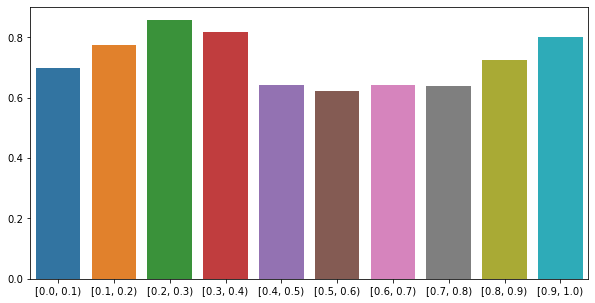

In [136]:
pct_correct = []


for i in range(10):
    subset = correctness_frame[correctness_frame.probability>= i *.1]
    subset = subset[subset.probability <(i+1)*.1]

#     subset = correctness_frame[correctness_frame.probability>=i]
    subset['correct'] = subset['true'] == subset['estimate']
    pct_correct.append(subset.correct.sum() / subset.shape[0])
    
bar_names = ['[' + str(np.around((i-1)*.1, decimals=1)) + ', ' + str(np.around((i)*.1, decimals=1)) +')'  for i in range(1,11)]
print(pct_correct, bar_names)#, steps)
#subset
fig= plt.figure(figsize=(10,5))
sns.barplot(x=bar_names, y=pct_correct, ci=None)

plt.show()

In [137]:
overall_probability_accuracy = pd.DataFrame([pct_correct], columns=bar_names)
metrics_frame = metrics_frame.append(pd.DataFrame({"AUC":[metrics_frame.AUC.mean(), confidence_interval(metrics_frame.AUC)], "Accuracy":[metrics_frame.Accuracy.mean(), confidence_interval(metrics_frame.Accuracy)], "Precision":[metrics_frame.Precision.mean(), confidence_interval(metrics_frame.Precision)],'Round':['Average', '.95 CI'], 'Recall':[metrics_frame.Recall.mean(), confidence_interval(metrics_frame.Recall)], 'F1':[metrics_frame.F1.mean(), confidence_interval(metrics_frame.F1)]}), ignore_index=True)

In [91]:
X_train_total = df_local_features_train_copy
y_train_total = df_local_names_copy

rfc=RandomForestClassifier(criterion='gini', n_estimators=1000,  n_jobs=-1, random_state=2020)    ## max_leaf_nodes=20, max_depth=30,min_samples_leaf=1,
sme = SMOTE(random_state=2020, sampling_strategy=.5, n_jobs=-1, k_neighbors=20)
X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train_total, y_train_total)
rfc.fit(X_train_oversampled,y_train_oversampled)


total_train_test = pd.DataFrame()
total_train_test['Protein Name'] = df_local_protein_names_classify_copy
total_train_test['In Corona Probability'] = rfc.predict_proba(df_local_features_classify_copy)[:, 1]

In [94]:
# total_train_test
top_features = pd.Series(rfc.feature_importances_,index=list(X_train_total.columns))
top_features.sort_values(ascending=False).to_excel('Top_RFC_selected_features.xlsx')

In [140]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('2021_05_22_predictions_selected_proteins.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.

predictions.to_excel(writer, sheet_name='Round Based Prediction')
metrics_frame.to_excel(writer, sheet_name='Classifier Round Metrics')
protein_avg_predictions.to_excel(writer, sheet_name='Protein Average Predictions')
overall_probability_accuracy.to_excel(writer, sheet_name='Overall Probability Accuracy')
total_train_test.to_excel(writer, sheet_name='Total Set Used in Prediction')


# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [141]:
count_proxy  = total_train_test.copy()
count_proxy['In Corona'] = count_proxy['In Corona Probability'] >= 0.5 
print(count_proxy['In Corona'].sum())

2


In [142]:
count_proxy[count_proxy['In Corona']==True]

,Protein Name,In Corona Probability,In Corona
1,TAR DNA-binding protein 43 (TDP-43),0.551352,True
2,CD44 antigen (CDw44) (Epican) (Extracellular m...,0.570950,True


## Feature Add In Importance Test

In [144]:
k_readouts ={}
first_loop = True
first_feat=True
kselect_params={}
trials = 100
# skf = StratifiedKFold(n_splits=trials, shuffle=True, random_state=35)
sss = StratifiedShuffleSplit(n_splits=trials, test_size=0.1, random_state=2020)
# scaled_df = scaled_df.drop(['Unnamed: 0.1'], axis=1)
# for pca_frac in np.around(np.arange(.95, 1.001, .01), decimals=2):
#for prefit in ['mean', '1.25*mean', '1.5*mean', '1.75*mean', '2.0*mean']:
feature_imp = pd.DataFrame(columns=list(df_local_features_train.columns))
for k_feat in range(1, 90, 1):   
    i = 0

    
    init_scores_rfc = True
    first_roc_rfc = True
    for train_index, test_index in sss.split(df_local_features_train, df_local_names):
    
        X_train = df_local_features_train.iloc[train_index]
        X_test = df_local_features_train.iloc[test_index]
        y_train = df_local_names.iloc[train_index]
        y_test = df_local_names.iloc[test_index]    
        #### END COMMENT OUT 
        if init_scores_rfc:  # use this to record data for ROC curves -- Some may be moved to outside the loop
            y_score_array_rfc = np.zeros((y_test.shape[0], trials))
            y_true_array_rfc = np.zeros((y_test.shape[0], trials))
            tpr_array_rfc = np.zeros((y_test.shape[0], trials))
            fpr_array_rfc = np.zeros((y_test.shape[0], trials))
            score_rfc = np.zeros(trials)
            score_svm = np.zeros(trials)
            auc_data_rfc = np.zeros(trials)
            f1_rfc = np.zeros(trials)
            fbeta_rfc = np.zeros(trials)
            recall_rfc = np.zeros(trials)
            precision_rfc = np.zeros(trials)
            log_loss_rfc = np.zeros(trials)
            features_left = np.zeros(trials)
            
            init_scores_rfc = False # Don't Come Back Here
        
        # Create and Train
        rfc=RandomForestClassifier(criterion='gini', n_jobs=-1, random_state=2020, n_estimators=1000)
                                #min_samples_split=4, min_samples_leaf= 2, max_features= 'log2', max_depth = 10)    ## max_leaf_nodes=20, 
        
        # feature extraction
        k_best = SelectKBest(score_func=f_classif, k=k_feat)
        # fit on train set
        fit = k_best.fit(X_train, y_train)
        
        X_train_transformed = fit.transform(X_train)
        X_test_transformed = fit.transform(X_test)
        
        sme = SMOTE(random_state=2020, sampling_strategy=.5, n_jobs=-1, k_neighbors=20)
        X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train_transformed, y_train)
        
        rfc.fit(X_train_oversampled,y_train_oversampled)

        # Basic Predictions
        y_pred_test = rfc.predict(X_train_oversampled) 
        y_pred_train = rfc.predict(X_test_transformed)
        

        
        # Calculate Metrics
        auc_data_rfc[i] = metrics.roc_auc_score(y_test, rfc.predict_proba(X_test_transformed)[:, 1])
        score_rfc[i] =  rfc.score(X_test_transformed, y_test)

        f1_rfc[i] = f1_score(y_test, rfc.predict(X_test_transformed))
        fbeta_rfc[i] = fbeta_score(y_test, rfc.predict(X_test_transformed), beta=0.5)
        recall_rfc[i] = recall_score(y_test, rfc.predict(X_test_transformed))
        precision_rfc[i] = precision_score(y_test, rfc.predict(X_test_transformed))
        log_loss_rfc[i] = log_loss(y_test, rfc.predict_proba(X_test_transformed)[:, 1])
        fpr_current_list, tpr_current_list, _ = metrics.roc_curve(y_test, rfc.predict_proba(X_test_transformed)[:, 1])


        if first_roc_rfc:  # Initialize 
            fpr_array_rfc = fpr_current_list
            tpr_array_rfc = tpr_current_list
            first_roc_rfc = False  # Don't Come back Here
            
        else:
            fpr_array_rfc = np.concatenate((fpr_array_rfc, fpr_current_list))
            tpr_array_rfc = np.concatenate((tpr_array_rfc, tpr_current_list))
#         i+=1
        column_list = list(scaled_df.columns)
        
        if first_feat:
            feat_revolve = pd.DataFrame(rfc.feature_importances_,index=[column_list[i] for i in np.nonzero(k_best.get_support())[0]]).transpose()
            feat_revolve['Features'] = k_feat
            feature_imp = feat_revolve.copy()
            first_feat = False
            
            
        else:
            feat_revolve = pd.DataFrame(rfc.feature_importances_,index=[column_list[i] for i in np.nonzero(k_best.get_support())[0]]).transpose()
            feat_revolve['Features'] = k_feat
            feature_imp = feature_imp.append(feat_revolve.copy(), ignore_index=True)

        kselect_params[str(k_feat)]=k_best.get_support()
        
        i+=1

    k_readouts[str(k_feat)] = {'Accuracy rfc': score_rfc.mean(),
                               'Accuracy rfc ci': confidence_interval(score_rfc),
                               'ROC Score rfc': auc_data_rfc.mean(), 
                               'ROC Score rfc ci': confidence_interval(auc_data_rfc),
                               'Precision rfc': precision_rfc.mean(),
                               'Precision rfc ci': confidence_interval(precision_rfc),
                               'Recall rfc': recall_rfc.mean(),
                               'Recall rfc ci': confidence_interval(recall_rfc),
                               'Accuracy svm': score_svm.mean(),
                               "Accuracy svm ci" : confidence_interval(score_svm)}
    print(f'K Criteria: {k_feat}\nAccuracy: {score_rfc.mean():.03f} +/- {confidence_interval(score_rfc):.03f}\nROC Score: {auc_data_rfc.mean():.03f} +/- {confidence_interval(auc_data_rfc):.03f}\n ') #Features Left: {features_left.mean():.1f} +/- {confidence_interval(features_left):.02f}')

K Criteria: 1
Accuracy: 0.623 +/- 0.022
ROC Score: 0.580 +/- 0.024
 
K Criteria: 2
Accuracy: 0.661 +/- 0.021
ROC Score: 0.606 +/- 0.028
 
K Criteria: 3
Accuracy: 0.685 +/- 0.019
ROC Score: 0.638 +/- 0.027
 
K Criteria: 4
Accuracy: 0.681 +/- 0.019
ROC Score: 0.658 +/- 0.026
 
K Criteria: 5
Accuracy: 0.697 +/- 0.018
ROC Score: 0.666 +/- 0.027
 
K Criteria: 6
Accuracy: 0.708 +/- 0.019
ROC Score: 0.671 +/- 0.026
 
K Criteria: 7
Accuracy: 0.709 +/- 0.017
ROC Score: 0.674 +/- 0.024
 
K Criteria: 8
Accuracy: 0.713 +/- 0.017
ROC Score: 0.677 +/- 0.026
 
K Criteria: 9
Accuracy: 0.701 +/- 0.018
ROC Score: 0.674 +/- 0.026
 
K Criteria: 10
Accuracy: 0.701 +/- 0.017
ROC Score: 0.675 +/- 0.025
 
K Criteria: 11
Accuracy: 0.704 +/- 0.018
ROC Score: 0.671 +/- 0.025
 
K Criteria: 12
Accuracy: 0.702 +/- 0.019
ROC Score: 0.680 +/- 0.025
 
K Criteria: 13
Accuracy: 0.702 +/- 0.018
ROC Score: 0.682 +/- 0.025
 
K Criteria: 14
Accuracy: 0.708 +/- 0.018
ROC Score: 0.683 +/- 0.025
 
K Criteria: 15
Accuracy: 0.70

In [145]:
first_key = True
for key in k_readouts.keys():
    
    if first_key:
        k_feats_data = pd.DataFrame.from_dict(data=k_readouts[key],orient='index').transpose()
        k_feats_data['K Features'] = int(key)
        first_key=False
        
    else: 
        k_feats_data_rotating = pd.DataFrame.from_dict(data=k_readouts[key],orient='index').transpose()
        k_feats_data_rotating['K Features'] = int(key)
        k_feats_data = k_feats_data.append(k_feats_data_rotating, ignore_index=True)
        
k_feats_data = k_feats_data.set_index('K Features')
k_feats_data.to_excel('data_for_feature_add_in_figure_updated.xlsx')        